In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, optimizers, layers

### 1. 准备数据

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
print(housing.data[0:5])
print(housing.target[0:5])

[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.78800000e+01 -1.22230000e+02]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  9.71880492e-01
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02]
 [ 7.25740000e+00  5.20000000e+01  8.28813559e+00  1.07344633e+00
   4.96000000e+02  2.80225989e+00  3.78500000e+01 -1.22240000e+02]
 [ 5.64310000e+00  5.20000000e+01  5.81735160e+00  1.07305936e+00
   5.58000000e+02  2.54794521e+00  3.78500000e+01 -1.22250000e+02]
 [ 3.84620000e+00  5.20000000e+01  6.28185328e+00  1.08108108e+00
   5.65000000e+02  2.18146718e+00  3.78500000e+01 -1.22250000e+02]]
[4.526 3.585 3.521 3.413 3.422]


**数据分割**

In [4]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


**归一化**

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

### 2. 使用网格搜索寻找超参数

In [15]:
x_train.shape[1:]

(8,)

In [16]:
# RandomizedSearchCV
# 1. 把模型转化为 sklearn 中的 model
# 2. 定义参数集合
# 3. 搜索参数

def build_mode(hidden_layers = 1, layer_size = 30, learning_tate=3e-3):
    model = keras.Sequential()
    # model.add(keras.layers.Input(input_shape=(None, 8)))
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                input_shape = x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(learning_tate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

# model.build(input_shape=(None, 8))

# 1. 把模型转化为 sklearn 中的 model
sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=build_mode)
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, min_delta=1e-2)
]
history = sklearn_model.fit(x_train_scaled, y_train, 
                    validation_data=(x_valid_scaled, y_valid),
                   epochs=10, callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 86us/sample - loss: 1.2988 - val_loss: 0.7091
Epoch 2/10
11610/11610 [==============================] - 1s 61us/sample - loss: 0.6165 - val_loss: 0.6339
Epoch 3/10
11610/11610 [==============================] - 1s 84us/sample - loss: 0.5579 - val_loss: 0.5853
Epoch 4/10
11610/11610 [==============================] - 1s 63us/sample - loss: 0.5239 - val_loss: 0.5466
Epoch 5/10
11610/11610 [==============================] - 1s 60us/sample - loss: 0.5026 - val_loss: 0.5271
Epoch 6/10
11610/11610 [==============================] - 1s 74us/sample - loss: 0.4834 - val_loss: 0.5055
Epoch 7/10
11610/11610 [==============================] - 1s 62us/sample - loss: 0.4743 - val_loss: 0.4943
Epoch 8/10
11610/11610 [==============================] - 1s 61us/sample - loss: 0.4694 - val_loss: 0.4872
Epoch 9/10
11610/11610 [==============================] - 1s 63us/sample - loss: 0.4596 - val_l

In [33]:
# sklearn_model.fit?

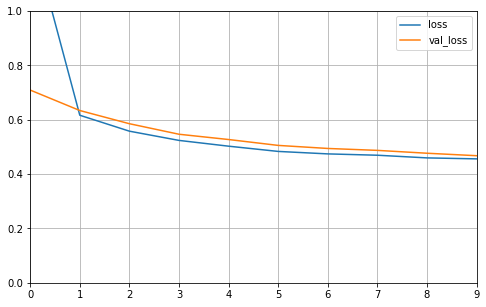

In [17]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [40]:
# 2. 定义参数集合
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size": [i for i in range(1, 50)],
    # "learning_rate": reciprocal(1e-4, 1e-2),
}
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
# random_search_cv.fit(x_train_scaled, y_train)

In [36]:
random_search_cv.best_estimator_

In [37]:
random_search_cv.best_params_

{'layer_size': 40, 'hidden_layers': 2}

In [38]:
random_search_cv.best_score_

-0.6947100168076391

In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test, verbose=2)